In [1]:
import numpy as np
import dlib
import os
import cv2
from torchvision.transforms import ToPILImage
import os
import torch
import pandas as pd
import numpy as np
import math
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        print('hi')
        return torch.device('cpu')

In [3]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets= batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [4]:
class ActionResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Using a pretrained model
        self.network = models.resnet34(pretrained=True) #pretrained states that the model is taken with trained weights.
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 256)
        #Adding top layers for better performance.
        self.network1=nn.Linear(256,8)
        self.networkact=nn.ReLU()
        self.softmax=nn.Softmax(dim=1)
    
    def forward(self, xb):
        out=self.network(xb)
        out=self.networkact(out)
        out=self.network1(out)
        return self.softmax(out) #for matrices dimension is 1 as we say to model to do softmax to the last dimension(i.e vectors)
    #the below function will make only the top layers to be available for training i.e the layers we added.
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    #the below function will make the entire model trainable.
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [5]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [6]:
device = get_default_device()

In [7]:
import torch 
path='../input/action-certainer/sequence.pth'
model =to_device(ActionResNet(),device)
#model.eval()
model.load_state_dict(torch.load(path))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


<All keys matched successfully>

In [8]:
model.eval()

ActionResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [9]:
DATA_DIR = "../input/fight-dataset/actions (2)/actions" #root directory comtaning the dataset.

TRAIN_DIR = DATA_DIR + '/train'                           # Sub-directory containing training images
TEST_DIR = DATA_DIR + '/test'                             # Sub-directory containing test images

In [10]:
#Initializing the values needed.
batch_size = 64 
stats = ([0.485, 0.456, 0.406] #mean value of each channel in imagenet dataset.
         , [0.229, 0.224, 0.225]) #standard deviation value of each channel in imagenet dataset.
image_size=224 #size of the image required.

In [11]:
#ImageFolder is very useful for image datasets as it takes the labels from the folder names and sends the images accordingly to the model.
train_ds = ImageFolder(TRAIN_DIR, transform=T.Compose([
    T.Resize((image_size,image_size)), #getting all the iamges of unique size as the images in the dataset may be of different sizes.
    T.ToTensor(), #converts the arrays to tensor.
    T.Normalize(*stats)])) #Normalizing the data which will be very useful for early convergence during training.
#val denotes validation set.Here we will use our test data as validation data.
val_ds = ImageFolder(TEST_DIR, transform=T.Compose([
    T.Resize((image_size,image_size)),
    T.ToTensor(),
    T.Normalize(*stats)])) #'*' will make the tuple values according to arguements.

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) #The last two parameters are used to optimize the loading of the data to the gpu.
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0] 
#The below 2 functions are used for visualizing the images in grid form.

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
    

In [14]:
labels_str={
0:"Hit",
1:"Kick",
2:"Punch",
3:"Push",
4:"ridehorse",
5:"shootgun",
6:"stand",
7:"wave/none"}

In [15]:
def predict_single(image,label):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)  #to load the image to the gpu memory.
    preds = model(xb)
    prediction = preds[0]
    return [labels_str[torch.argmax(prediction).tolist()],labels_str[label]]
    #print("Actual Label: ",labels_str[label])
    #print("Prediction: ", labels_str[torch.argmax(prediction).tolist()]) #The predicted class is extracted from the predicted values.
    #show_images(image)

In [16]:
Pre_seq=[]
for i in range(len(val_ds)):
    Pre_seq.append(predict_single(val_ds[i][0],val_ds[i][1]))

In [17]:
t1=[]
t2=[]
for i in range(len(Pre_seq)):
    t1.append(Pre_seq[i][0])
    t2.append(Pre_seq[i][1])

In [18]:
from sklearn.metrics import confusion_matrix
cf=confusion_matrix(t1,t2)
print(cf)

[[ 424    6    0    5    2    0   16   10]
 [   0  345    0    0   12   23  207   85]
 [   0  152  201    0   16    0   72  404]
 [   0    0    0  773    0    0    0   90]
 [   0    0    0    0 1314    0    0   18]
 [   0   11    0    0    0  777    2   28]
 [   0   16    0    0    7   18  423  657]
 [   0    0    0    0    0   10  155 1528]]


Most Useful Inference Weapon Detection
Look Row 5 
5679 Frames with Weapon Correctly Pointed out only 2 False Positives

In [19]:
total_correct=cf[0][0]+cf[1][1]+cf[2][2]+cf[3][3]+cf[4][4]+cf[5][5]+cf[6][6]+cf[7][7]
print('Total Length',len(t1))
print('Correctly predicted',total_correct)
acc=total_correct/len(t1)
print('Accuracy',acc)

Total Length 7807
Correctly predicted 5785
Accuracy 0.7410016651722813


In [21]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(images)

In [22]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [23]:
INPUT_PATH='../input/fer13-cleaned-dataset/'

In [24]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

fear has 2535 number of images
Happy has 6834 number of images
Neutral has 4295 number of images
Angry has 2832 number of images
disgust has 380 number of images

total images are 16876


In [25]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [26]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all Angry images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

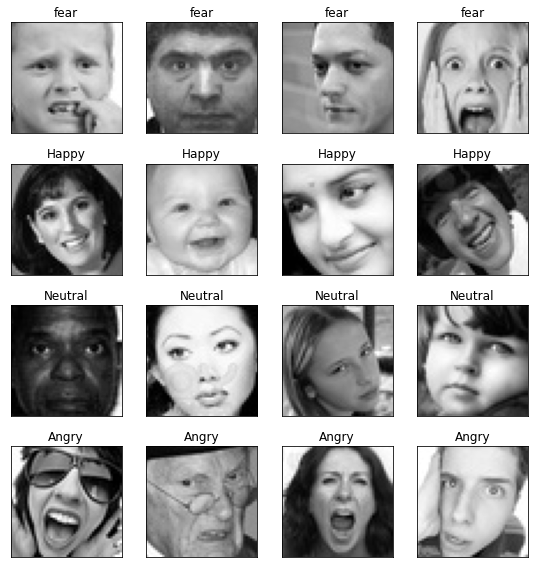

In [27]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [28]:
img_label = np_utils.to_categorical(img_label)

In [29]:
img_arr = img_arr / 255.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)

In [31]:
del img_arr
del img_label

In [32]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [33]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

17227776/17225924 [==============================] - 0s 0us/step


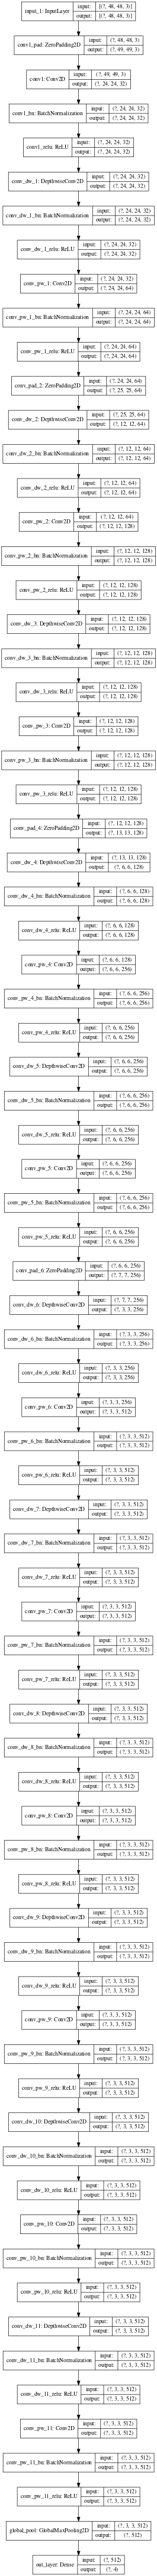

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')


In [35]:
for layer in model.layers[:15]:
    layer.trainable = False

In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [37]:

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [38]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/40
594/593 [==============================] - 17s 29ms/step - loss: 1.3958 - accuracy: 0.4446 - val_loss: 1.2414 - val_accuracy: 0.5467 - lr: 0.0100
Epoch 2/40
594/593 [==============================] - 15s 26ms/step - loss: 1.0503 - accuracy: 0.5645 - val_loss: 1.0521 - val_accuracy: 0.5964 - lr: 0.0100
Epoch 3/40
594/593 [==============================] - 16s 27ms/step - loss: 0.9520 - accuracy: 0.6188 - val_loss: 0.9168 - val_accuracy: 0.6158 - lr: 0.0100
Epoch 4/40
594/593 [==============================] - 16s 28ms/step - loss: 0.9138 - accuracy: 0.6353 - val_loss: 0.8661 - val_accuracy: 0.6739 - lr: 0.0100
Epoch 5/40
594/593 [==============================] - 16s 27ms/step - loss: 0.8781 - accuracy: 0.6489 - val_loss: 0.9021 - val_accuracy: 0.6527 - lr: 0.0100
Epoch 6/40
594/593 [==============================] - 16s 26ms/step - loss: 0.8602 - accuracy: 0.6544 - val_loss: 0.8519 - val_accuracy: 0.6479 - lr: 0.0100
Epoch 7/40
594/593 [==============================] - 16s 

In [39]:
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

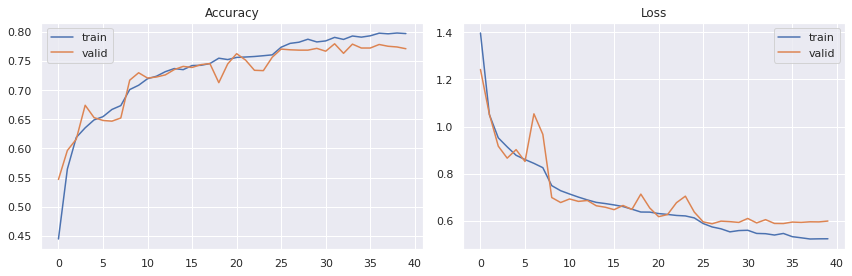

In [40]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [41]:
label_to_text

{0: 'fear', 1: 'Happy', 2: 'Neutral', 3: 'Angry'}

In [42]:
text_to_label = dict((v,k) for k,v in label_to_text.items())

test accuracy: 77.0909 %


              precision    recall  f1-score   support

           0       0.75      0.56      0.64       253
           1       0.92      0.88      0.90       684
           2       0.67      0.82      0.74       430
           3       0.62      0.63      0.62       283

    accuracy                           0.77      1650
   macro avg       0.74      0.72      0.73      1650
weighted avg       0.78      0.77      0.77      1650



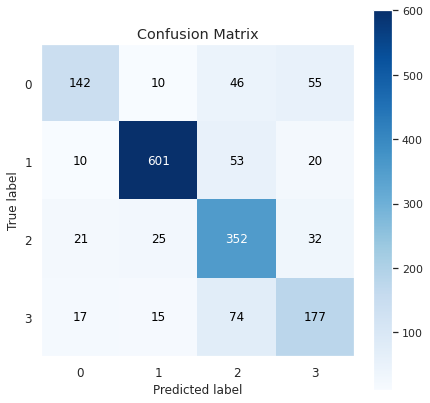

In [43]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

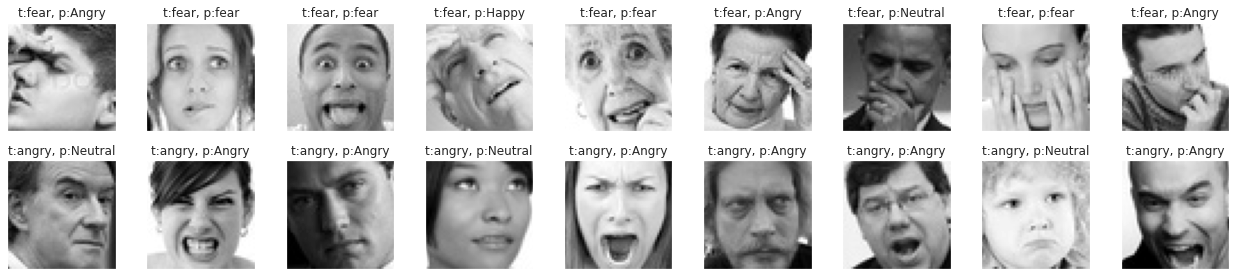

In [44]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

In [45]:
import PIL
def predict_one(path):
    img=PIL.Image.open(path)
    img=img.resize((48,48),3)
    img=np.array(img).reshape(1,48,48,3)
    return np.argmax(model.predict(img))

In [47]:
path='../input/action-certainer/sequence.pth'
seq_model =to_device(ActionResNet(),device)
#model.eval()
seq_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [136]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)  #to load the image to the gpu memory.
    preds = seq_model(xb)
    prediction = preds[0]
    return labels_str[torch.argmax(prediction).tolist()]

In [80]:
INPUT_PATH='../input/fight-dataset/actions (2)/actions/train/'

In [135]:
from PIL import Image
from torchvision.transforms import ToTensor
from torch.autograd import Variable


def convert_img(path):
    image = Image.open(img_path)
    image=image.resize((64,64))
    image = ToTensor()(image) # unsqueeze to add artificial first dimension
    image = Variable(image)
    return image

In [133]:
def predict_seq(path):
    #print(convert_img(path).shape)
    return predict_single(convert_img(path))
    
    

In [134]:
def predict(path):
    a=predict_seq(path)
    b=label_to_text[predict_one(path)]
    return [a,b]
    

In [138]:
ans=[]
i=0
for dir_ in os.listdir(INPUT_PATH):
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            if(i<300):
                i+=1
                path=INPUT_PATH + dir_ + "/" + f
                l=predict(path)
                ans.append(l)